# Data

In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression  # for OLS, WLS
from statsmodels.regression.mixed_linear_model import MixedLM  # for MLE
from cvxopt import matrix, solvers  # for long only portfolio
solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'Data/Data/Data' # use your path
allFiles = glob.glob(path + "/*.txt")

list_df = []

for file_ in allFiles:
    df = pd.read_csv(file_, index_col=None, header=0, sep="|")
    list_df.append(df)

print('Reading file ...Done')

Reading file ...Done


In [3]:
data = pd.concat(list_df, axis = 0, ignore_index = True)
data['XDATE'] = pd.to_datetime(data['XDATE'])
data['T'] = pd.to_datetime(data['T'])
data['RDATE'] = pd.to_datetime(data['RDATE'])
print('Combining file ...Done')

Combining file ...Done


## Data prep
(1) ID: a unique stock identifier that doesn't change through time  
(2) NAME: the name of the corporation, for example EXXON MOBIL CORP  
(3) BETA, MOMENTUM, SIZE, VOL: style factor loadings, which becomes columns of X  
(4) GICCODE (Categorical): an industry classification, which you can treat as a categorical factor, whose unique levels become columns of X  
(5) XDATE: the date on which the factor loadings are sampled, usually one trading day before T  
(6) T: the date t in Rt;t+1  
(7) RDATE: the date t + 1 in Rt;t+1  
(8) R: the numerical value of Rt;t+1  
(9) RESVOL (used in WLS): the value of sigma_i for this stock, estimated using data knowable before t  
(10) ADVP: average daily volume times price, in dollars  
(11) tir, td (has NaN): alpha factors, sampled before t, which may or may not help predict R  

In [4]:
num_col = ['BETA', 'SIZE', 'MOMENTUM', 'VOL', 'ADVP', 'USDCAP', 'RESVOL', 'tir', 'td']
cat_col = ['GICCODE']
na_col = ['tir', 'td']
y_col = ['R']

### Delete outlier
return on 2013-12-31 has error, delete this date

In [5]:
data_desc = data.groupby(['T'])[y_col[0]].describe()

In [6]:
data_desc[data_desc['max'] > 5]

,count,mean,std,min,25%,50%,75%,max
T,,,,,,,,
2013-12-31,2718.0,3.893213,190.133541,-0.859219,-0.018969,-0.010547,-0.001719,9910.688817


In [7]:
error_date = data_desc[data_desc['max'] > 5].index.values[0]
error_date

numpy.datetime64('2013-12-31T00:00:00.000000000')

In [8]:
data = data[data['T'] != error_date]
print('Remove data of date: {} ...Done'.format(error_date))

Remove data of date: 2013-12-31T00:00:00.000000000 ...Done


### Encode categorical values
one hot encoder: encode categorical variables to dummy

In [9]:
data = pd.concat([data, pd.get_dummies(data[cat_col[0]], prefix=cat_col[0])], axis=1)
data.drop(cat_col, axis=1, inplace=True)
print('Encoding column {} ...Done'.format(cat_col[0]))

Encoding column GICCODE ...Done


In [10]:
cat_col = list(data.columns.values[15:])  # all GICCODE
factor_col = ['BETA', 'SIZE', 'MOMENTUM', 'VOL', 'tir', 'td']
X_col = factor_col + cat_col
y_col = ['R']  # y column names

### Deal with NA values
only tir and td have NA values  
tir: all NAs for some of assets, replace with 0  
td: some NAs for some of assets, replace with previous value  

In [11]:
data[na_col] = data.groupby(['ID'], as_index=False)[na_col].fillna(method='ffill').fillna(0)

# Problem 1

In [12]:
# data multi-indexed by date and id
data_dt_id = data.set_index(['T','ID']).sort_index(level=[0,1])

In [16]:
len(data_dt_id.index)

7116602

In [13]:
data_dt_id.index.levels[0]

DatetimeIndex(['2007-01-03', '2007-01-04', '2007-01-05', '2007-01-08',
               '2007-01-09', '2007-01-10', '2007-01-11', '2007-01-12',
               '2007-01-16', '2007-01-17',
               ...
               '2017-12-14', '2017-12-15', '2017-12-18', '2017-12-19',
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-26',
               '2017-12-27', '2017-12-28'],
              dtype='datetime64[ns]', name='T', length=2767, freq=None)

In [14]:
data_dt_id.index.levels[1]

Index(['10000_01', '10002_02', '10008_01', '10016_01', '10035_01', '10044_01',
       '1004_01', '10056_01', '10063_01', '10086_01',
       ...
       '9890_01', '9898_01', '9899_01', '9904_01', '9919_01', '9921_01',
       '9922_01', '9937_01', '9969_02', '9999_01'],
      dtype='object', name='ID', length=5155)

In [15]:
data_dt_id.columns

Index(['NAME', 'BETA', 'SIZE', 'MOMENTUM', 'VOL', 'XDATE', 'RDATE', 'R',
       'ADVP', 'USDCAP',
       ...
       'GICCODE_60101030', 'GICCODE_60101040', 'GICCODE_60101050',
       'GICCODE_60101060', 'GICCODE_60101070', 'GICCODE_60101080',
       'GICCODE_60102010', 'GICCODE_60102020', 'GICCODE_60102030',
       'GICCODE_60102040'],
      dtype='object', length=189)

## OLS / WLS

In [122]:
# dataframe to store factor returns: index is date, column are factor names
factor_ret_ols = pd.DataFrame(columns = X_col)
factor_ret_wls = pd.DataFrame(columns = X_col)

In [ ]:
def compute_factor_ret():
    global factor_ret_ols, factor_ret_wls
    
    start = datetime.now()
    lm = LinearRegression(fit_intercept = False)

    for dt in data_dt_id.index.levels[0]:
        print('Calculating factor return for day {} ...Done'.format(dt))

        # dataframe indexed by ID for each trading day
        df = data_dt_id.loc[dt, :]
        df = df[df[y_col[0]]!=0]  # delete stocks that have 0 returns(y)
        y = df[y_col]  # returns

        # keep column name that have any non-zero values
        nna_col = df.columns[(df != 0).any()]
        df_X = df[nna_col]  # remove columns that are all 0

        df_X = pd.concat([df_X[factor_col], df_X.loc[:, cat_col[0]:]], axis=1)  # combine 6 factor column + categorical columns
        X = df_X.values

        # OLS: store factor return
        f = np.linalg.inv(X.T@X)@X.T@y  # factor value at t+1, place at t, shift it later
        factor_ret_ols.loc[dt, df_X.columns] = f.T[0]

        # WLS
        df.loc[df['RESVOL'] < 0.005, 'RESVOL'] = 0.005  # replace small resvol values
        prob = df.RESVOL ** 2
        factor_ret_wls.loc[dt, df_X.columns] = lm.fit(X, y, sample_weight = 1/prob).coef_
    
    print(">>> Running Time : ", datetime.now() - start)

In [ ]:
compute_factor_ret()

In [126]:
factor_ret_ols.to_csv('factor_ret_ols.csv')
factor_ret_wls.to_csv('factor_ret_wls.csv')
print('Saved to file ...Done')

Saved to file ...Done


## Compare cumsum factor return

In [9]:
factor_ret_ols = pd.read_csv('factor_ret_ols.csv', index_col=0, parse_dates=True)
factor_ret_wls = pd.read_csv('factor_ret_wls.csv', index_col=0, parse_dates=True)

In [10]:
factor_ret_ols_cumsum = factor_ret_ols.cumsum()
factor_ret_wls_cumsum = factor_ret_wls.cumsum()

In [11]:
alpha_col = ['tir', 'td']

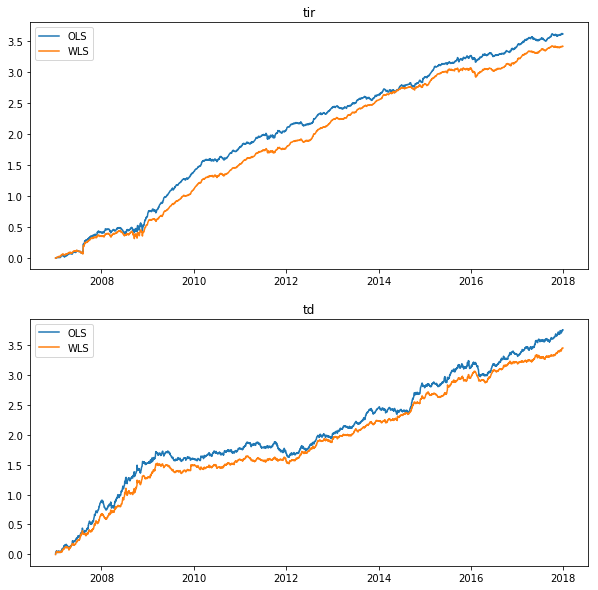

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
for i in range(2):
    col = alpha_col[i]
    ax[i].plot(factor_ret_ols_cumsum[col], label='OLS')
    ax[i].plot(factor_ret_wls_cumsum[col], label='WLS')
    ax[i].set_title(col)
    ax[i].legend()

In [16]:
pvalue_tir = ttest_ind(factor_ret_ols_cumsum['tir'], factor_ret_wls_cumsum['tir'])[1]
pvalue_td = ttest_ind(factor_ret_ols_cumsum['td'], factor_ret_wls_cumsum['td'])[1]
print('T test is used, p-value for factor tir is {}, p-value for factor td is {}'.format(pvalue_tir, pvalue_td))
print('Since their p-value are small, the results are significally different statistically ')

T test is used, p-value for factor tir is 5.350257891081695e-09, p-value for factor td is 1.0197837787552627e-11
Since their p-value are small, the results are significally different statistically 


## Mean factor return

In [32]:
factor_ret_wls_mean = factor_ret_wls.mean()
factor_ret_ols_mean = factor_ret_ols.mean()

In [14]:
factor_ret_ols_mean[:2]

BETA    0.000082
SIZE   -0.000056
dtype: float64

In [15]:
factor_ret_wls_mean[:2]

BETA    0.000055
SIZE   -0.000062
dtype: float64

# Problem 2

## Optimal holding
can use either gradient_descent/optimal_holding functions below to calculate optimal holding without forming sigma.  
To speed up process, I simply used optimal_holding function, which is given in Ritter's lecture note Theorem 5.2 (5.11).

In [936]:
# get exposure(x) and optimal holding(h) without forming sigma
def optimal_holding(kappa, F, X, D_inv, D_inv_half, factor_mean):
    exp_x = (1./kappa) * np.linalg.inv(F + np.linalg.pinv(X.T @ D_inv @ X)) @ factor_mean
    h = D_inv_half @ np.linalg.pinv(X.T @ D_inv_half) @ exp_x
    return h

In [ ]:
def gradient_descent(kappa, F, X, D_inv, D_inv_half, factor_mean):
    precision = np.array([0.001]*X.shape[1])
    step = 0.01
    x = np.zeros(X.shape[1])
    iters = 0
    max_iters = 10000
    
    while change > precision and iters < max_iters:
        x = new_x
        delta = factor_mean - kappa * (F + np.linalg.pinv(X.T @ D_inv @ X)) @ x
        new_x = x - delta * step
        h = D_inv_half @ np.linalg.pinv(X.T @ D_inv_half) @ x
        change = abs(new_x - x)
        
    return h

In [117]:
'''
Calculate optimal holding for each stock in each day given factor returns, kappa.
If no long only constraint, use previous optimization function to solve.
If add long only constraint, use cvxopt.solvers.qp to solve.
'''

def compute_optimal_holding(factor_ret, kappa=1, long_only=False):
    # save holdings: row is stocks, column is dates
    holding_df = pd.DataFrame(columns = data_dt_id.index.levels[1])

    start = datetime.now()
    print('Calculating optimal holding for Markowitz portfolio ...')

    for dt in factor_ret.index:    
        print(dt)
        # get X
        df = data_dt_id.loc[dt, :]
        df = df[df[y_col[0]]!=0]
        y = df[y_col]
        nna_col = df.columns[(df != 0).any()]
        df_X = df[nna_col]
        df_X = pd.concat([df_X[factor_col], df_X.loc[:, cat_col[0]:]], axis=1)
        X = df_X.values

        # expanding covariance
        F = factor_ret.loc[:dt, df_X.columns.values].cov().fillna(0).values

        # get D
        df.loc[df['RESVOL'] < 0.005, 'RESVOL'] = 0.005
        D = np.diagflat(df['RESVOL'].values ** 2)
        D_inv = np.diagflat(1. / df['RESVOL'].values ** 2)
        D_inv_half = np.diagflat(1. / df['RESVOL'].values)
        
        # get alpha: n*1
        alpha = df['td'].values + df['tir'].values
        
        if not long_only:
            factor_mean = np.linalg.pinv(X) @ alpha
            holding = optimal_holding(kappa, F, X, D_inv, D_inv_half, factor_mean)
        else:
            sigma = X @ F @ X.T + D
            G = - np.identity(len(alpha))
            h = np.zeros((len(alpha), 1))
            sol = solvers.qp(matrix(sigma), matrix(alpha), matrix(G), matrix(h))
            holding = np.array(sol['x'])
        
        # store into df
        holding_df.loc[dt, df_X.index.values] = holding.reshape(1,-1)

    print(">>> Running Time : ", datetime.now() - start)
    
    return holding_df

In [148]:
holding_df = compute_optimal_holding(factor_ret_ols)  # holding using k=1
holding_df.to_csv('holding_df.csv')
print('Saved to file ...Done')

Saved to file ...Done


## kappa
find constant kappa that the average gross market value of holdings is 500 million USD

In [20]:
holding_df = pd.read_csv('holding_df.csv', index_col=0, parse_dates=True)

In [21]:
'calculate kappa given holdings in each day'
def compute_kappa(holding_df, capital = 500000000.):
    kappa = holding_df.abs().sum(axis=1).mean() / capital
    print('kappa when average GMV is 500 million USD: {}'.format(kappa))
    return kappa

In [22]:
kappa = compute_kappa(holding_df)

kappa when average GMV is 500 million USD: 0.0012758191793538305


## P/L and Cost
given kappa and holdings, calculate pnl and corresponding cost

In [205]:
'''
calculate pnl with given holdings dataframe (time, stocks)
calculate_cost=True will include cost of trades by day
'''

def calculate_pnl(holding_df, k=1, calculate_cost=False):
    start = datetime.now()
    pnl_df = pd.DataFrame(columns=['pnl','cost'])

    # calculate trades for each day
    if calculate_cost:
        holding_change = abs((holding_df).fillna(0).diff())   

    for dt in holding_df.index:
        holding = holding_df.loc[dt,:].dropna()
        df = data_dt_id.loc[dt, :]
        y = df.loc[holding.index, y_col]
        hk = holding / k
        profit = (hk.values @ y.values)[0]
        # store
        pnl_df.loc[dt, 'pnl'] = profit

        # cost
        if calculate_cost:
            delta = holding_change.loc[dt,:]
            delta = delta[delta!=0]
            advp = df.loc[delta.index, 'ADVP']
            cost = 0.001 * delta**2 / (0.01 * advp)  # series of cost for each stock
            # store
            pnl_df.loc[dt, 'cost'] = cost.sum()

    print(">>> Running Time : ", datetime.now() - start)

    return pnl_df

In [ ]:
pnl_df = calculate_pnl(holding_df, kappa, calculate_cost=True)  # since holding_df is holdings with k=1, we want k=kappa
cumpnl_df = pnl_df.cumsum()
pnl_df.to_csv('pnl_df.csv')
cumpnl_df.to_csv('cumpnl_df.csv')
print('Saved to file ...Done')

In [24]:
cumpnl_df = pd.read_csv('cumpnl_df.csv', index_col=0, parse_dates=True)
pnl_df = pd.read_csv('pnl_df.csv', index_col=0, parse_dates=True)

In [25]:
# removing outliers
upper = pnl_df['pnl'].quantile(0.99)
lower = pnl_df['pnl'].quantile(0.01)
pnl_res = pnl_df.loc[upper > pnl_df['pnl'], :]
pnl_res = pnl_res.loc[lower < pnl_df['pnl'], :]
cumpnl_res = pnl_res.cumsum()

Text(0.5,1,'Cost')

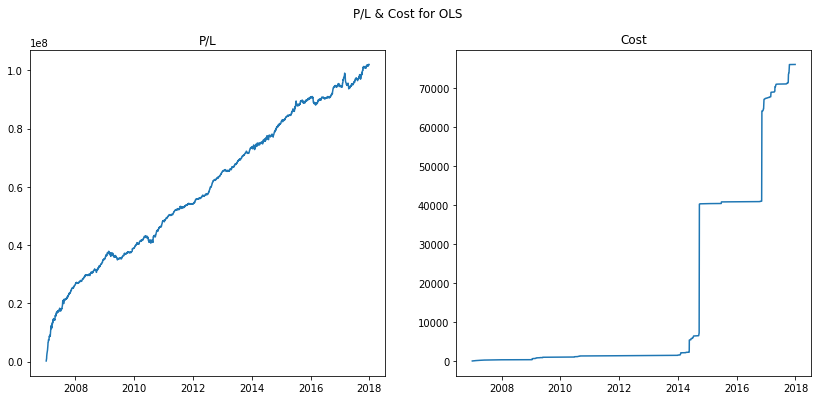

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plt.suptitle('P/L & Cost for OLS')
ax[0].plot(cumpnl_res['pnl'])
ax[0].set_title('P/L')
ax[1].plot(cumpnl_res['cost'])
ax[1].set_title('Cost')

## Risk decomposition
compute and plot percentage of variance in these portfolios due to alpha factors, non-alpha factors, idiosyncratic variance.

In [600]:
risk_df = pd.DataFrame(columns=np.append(factor_ret_ols.columns, 'idio_risk'))

In [601]:
for dt in holding_df.index:
    # get h: (stocks,1)
    holding = holding_df.loc[dt,:].dropna()
    h = holding.values
    
    # get X: (stocks,factors)
    df = data_dt_id.loc[dt, :]
    df = df.loc[holding.index,]
    nna_col = df.columns[(df != 0).any()]
    df_X = df[nna_col]
    df_X = pd.concat([df_X[factor_col], df_X.loc[:, cat_col[0]:]], axis=1)
    X = df_X.values

    # get F: (factors, factors)
    factor = factor_ret_ols.loc[:dt, df_X.columns.values].cov().fillna(0)
    F = factor.values

    # get D: (stocks, stocks)
    df.loc[df['RESVOL'] < 0.005, 'RESVOL'] = 0.005
    D = np.diagflat(df['RESVOL'].values ** 2)
    
    # risk
    sigma = X @ F @ X.T + D
    total_risk = h.T @ sigma @ h
    idio_risk = h.T @ D @ h
    idio_risk = idio_risk / total_risk
    
    # factor risk: alpha / non-alpha
    x = df_X.T @ h
    factor_risk = x * ((F @ x) / total_risk)
    
    # store
    risk_df.loc[dt, factor_risk.index] = factor_risk
    risk_df.loc[dt, 'idio_risk'] = idio_risk
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6631: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


In [612]:
risk_df.to_csv('risk_df.csv')
print('Saved to file ...Done')

Saved to file ...Done


In [27]:
risk_df = pd.read_csv('risk_df.csv', index_col=0, parse_dates=True)

In [59]:
# calculate percentage
variance_df = pd.DataFrame(columns=['alpha', 'non-alpha', 'idiosyncratic'])
variance_df['alpha'] = risk_df[alpha_col].sum(1)
variance_df['idiosyncratic'] = risk_df['idio_risk']
variance_df['non-alpha'] = 1 - variance_df['alpha'] - variance_df['idiosyncratic']

In [60]:
# getting rid of outliers
variance_df = variance_df[variance_df['idiosyncratic'] > 0]
variance_df = variance_df[variance_df['idiosyncratic'] < 1]
variance_df = variance_df[variance_df['non-alpha'] > -0.3]
variance_df = variance_df[variance_df['idiosyncratic'].diff() < 0.01]

Text(0.5,1,'Risk decomposition')

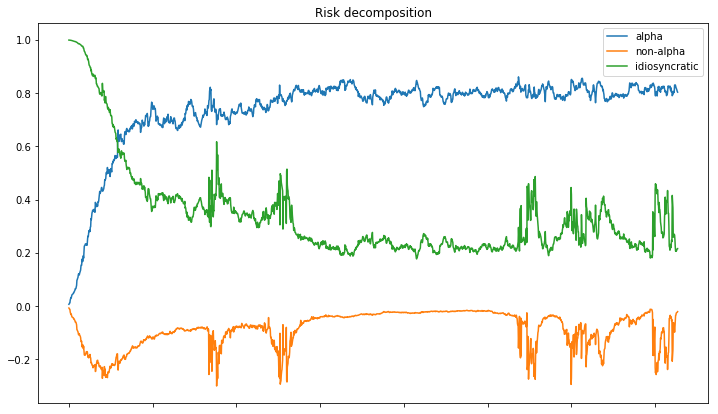

In [61]:
variance_df.plot(figsize=(12,7))
plt.title('Risk decomposition')

# Problem 3: Black-Litterman Optimization

In [674]:
capital = 500000000
q0 = 0.1
tau = 0.01
w = 0.01**2 

In [715]:
holding_KL_df = pd.DataFrame(columns = data_dt_id.index.levels[1])
holding_benchmark_df = pd.DataFrame(columns = data_dt_id.index.levels[1])

In [ ]:
'''
Compute black litterman portfolio holding, given:
P, C, omega, tau, kappa, hb, sigma, q0
'''

def compute_black_litterman(P, C, omega, tau, kappa, hb, sigma, q0):
    C_inv = np.linalg.inv(C)
    H = P.T @ omega @ P + C_inv
    H_inv = np.linalg.inv(H)
    pi = kappa * (1+tau) * sigma @ hb
    var = sigma + H_inv
    mean = H_inv @ (P.T @ omega * q0 + C_inv @ pi)
    holding_KL = 1 / kappa * np.linalg.inv(var) @ mean
    return holding_KL

In [751]:
for dt in data_dt_id.index.levels[0]:
    
    # get X: (stocks,factors)
    df = data_dt_id.loc[dt, :]
    df = df[df[y_col[0]]!=0]
    nna_col = df.columns[(df != 0).any()]
    df_X = df[nna_col]
    df_X = pd.concat([df_X[factor_col], df_X.loc[:, cat_col[0]:]], axis=1)
    X = df_X.values
    
    # get F: (factors, factors)
    factor = factor_ret_ols.loc[:dt, df_X.columns.values].cov().fillna(0)
    F = factor.values

    # get D: (stocks, stocks)
    D = np.diagflat(df['RESVOL'].values ** 2)
    
    # risk
    sigma = X @ F @ X.T + D
    C = tau * sigma
    
    # benchmark: by weight
    hb = capital * df['USDCAP'] / df['USDCAP'].sum()
    hb = hb[:,None]
    
    # Black Litterman
    P = df_X[['tir','td']].sum(1).values[None,:]
    omega = np.array(1./w).reshape(1,-1)
    holding_KL = compute_black_litterman(P, C, omega, tau, kappa, hb, sigma, q0)
    
    # store: becomes object
    holding_KL_df.loc[dt, df_X.index] = holding_KL.reshape(1,-1)
    holding_benchmark_df.loc[dt, df_X.index] = hb.reshape(1,-1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6631: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


In [788]:
# object convert to float
holding_KL_df = holding_KL_df.astype('float64')
holding_benchmark_df = holding_benchmark_df.astype('float64')
holding_KL_df.to_csv('holding_KL_df.csv')
holding_benchmark_df.to_csv('holding_benchmark_df.csv')
print('Saved to file ...Done')

Saved to file ...Done


In [811]:
KL_pnl = calculate_pnl(holding_KL_df, calculate_cost=False)

>>> Running Time :  0:00:11.895165


In [812]:
bench_pnl = calculate_pnl(holding_benchmark_df, calculate_cost=False)

>>> Running Time :  0:00:11.683776


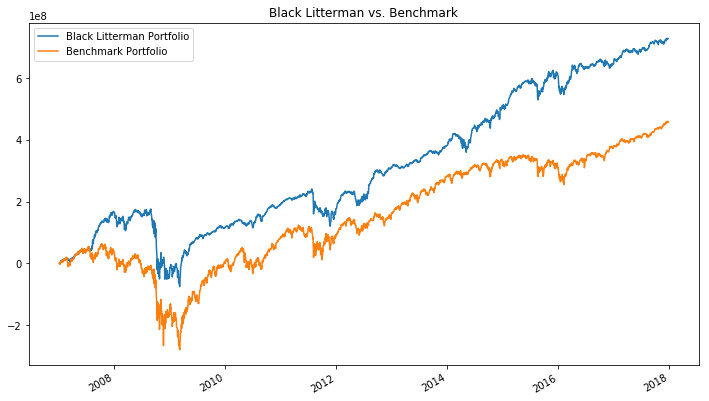

In [814]:
plt.figure(figsize=(12,7))
KL_pnl.cumsum()['pnl'].plot(label='Black Litterman Portfolio')
bench_pnl.cumsum()['pnl'].plot(label='Benchmark Portfolio')
plt.title('Black Litterman vs. Benchmark')
plt.legend()

# Problem 4: Mixed Effects Models

## Factor return for MLE
because of time constraint, EM function I wrote is not used but MixedLM package function is used.

In [ ]:
'EM algorithm'
def EM(T, holding_df):
    
    tol = 0.00001
    maxIter = 10000
    iteration = 0
    # initialize
    beta = np.zeros((data_dt_id.shape[1], 1))
    sig_e = 0  # sig_e^2
    F = np.identity(data_dt_id.shape[1])  # covariance of factor returns
    
    while(error > tol and iteration < maxIter):
        iteration += 1
        
        sum_XX = 0
        sum_Xb = 0
        count = 0
        
        for dt in data_dt_id.index.levels[0][:T]:
            count += 1
            # get X
            df = data_dt_id.loc[dt, :].fillna(0)
            df = df[df[y_col[0]]!=0]
            y = df[y_col]
            X = df.values
            
            D = np.identity(X.shape[0]) * sig_e
            sigma = X @ F @ X.T + D
            beta_hat = F @ X.T @ np.linalg.inv(sigma) @ y
            XX = X.T @ X
            error = (y - X @ beta_hat)
            Xb = X.T @ error
            sum_XX += XX
            sum_Xb += Xb
        
        # update beta
        beta = np.linalg.inv(sum_XX) @ sum_Xb
        I_inv = np.identity(len(error))
        sig_e = error.T @ I_inv @ error + sig_e * (np.linalg.matrix_rank(X) + len(beta)*count - 
                                                   sig_e * np.trace(Cuu @ np.linalg.inv(F)))
        sig_e = sig_e / X.shape[0]
        
        for i, dt in enumerate(holding_df.index):
            b = holding_df.loc[dt, :].fillna(0).values
            A_inv = np.identity(len(b))
            
            for j, dt2 in enumerate(holding_df.index):
                if dt2 != dt:
                    b2 = holding_df.loc[dt2, :].fillna(0).values
                    F1 = b.T @ A_inv @ b2 + sig_e * np.trace(A_inv @ Cuu)
                    F[i,j] = F1 / len(b)
        
    return beta  # for each T
        

In [1030]:
def compute_mle_holding(kappa=1):
    start = datetime.now()
    
    factor_ret_mle = pd.DataFrame(columns = factor_ret_ols.columns)
    holding_mle_df = pd.DataFrame(columns = holding_df.columns)

    for dt in data_dt_id.index.levels[0]:    
        # get X
        df = data_dt_id.loc[dt, :]
        df = df[df[y_col[0]]!=0]
        y = df[y_col]
        nna_col = df.columns[(df != 0).any()]
        df_X = df[nna_col]
        df_X = pd.concat([df_X[factor_col], df_X.loc[:, cat_col[0]:]], axis=1)
        X = df_X.values

        # MLE
        groups = np.arange(len(y))
        model = MixedLM(y, X, groups)  # using package
        lme_result = model.fit()
        beta = lme_result.fe_params
        F = lme_result.normalized_cov_params.iloc[:-1,:-1].values

        # store into df
        factor_ret_mle.loc[dt, df_X.columns.values] = beta.values

        # get D
        df.loc[df['RESVOL'] < 0.005, 'RESVOL'] = 0.005
        D = np.diagflat(df['RESVOL'].values ** 2)
        D_inv = np.diagflat(1. / df['RESVOL'].values ** 2)
        D_inv_half = np.diagflat(1. / df['RESVOL'].values)

        # get alpha: n*1
        alpha_factor_ret = factor_ret_mle.loc[dt, alpha_col]
        factor_mean = np.zeros((df_X.shape[1],1))
        factor_mean[4:6] = alpha_factor_ret.values.reshape(-1,1)

        h = optimal_holding(kappa, F, X, D_inv, D_inv_half, factor_mean)

        # store into df
        holding_mle_df.loc[dt, df_X.index.values] = h.reshape(1,-1)
    
    print(">>> Running Time : ", datetime.now() - start)
    return factor_ret_mle, holding_mle_df

In [1031]:
factor_ret_mle, holding_mle_df = compute_mle_holding()

>>> Running Time :  6:12:42.760407


In [1032]:
factor_ret_mle = factor_ret_mle.astype('float64')
factor_ret_mle.to_csv('factor_ret_mle.csv')
print('Saved to file ...Done')

Saved to file ...Done


In [1033]:
holding_mle_df = holding_mle_df.astype('float64')
holding_mle_df.to_csv('holding_mle_df.csv')
print('Saved to file ...Done')

Saved to file ...Done


## Compare with OLS alpha factor returns

In [28]:
factor_ret_mle = pd.read_csv('factor_ret_mle.csv', index_col=0, parse_dates=True)
holding_mle_df = pd.read_csv('holding_mle_df.csv', index_col=0, parse_dates=True)


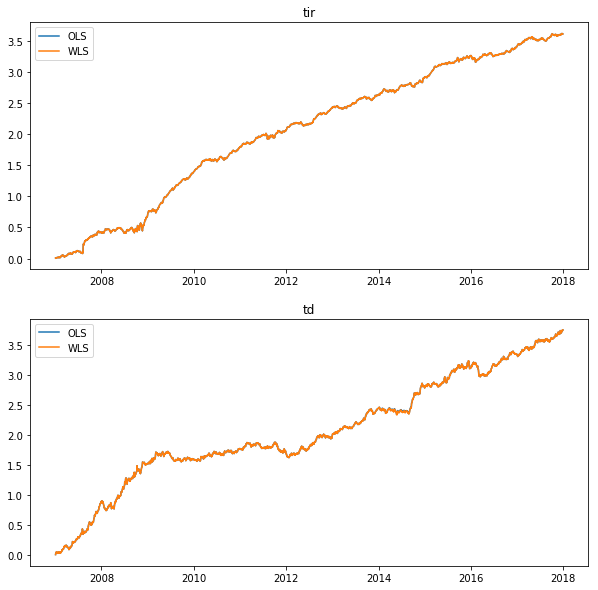

In [29]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
for i in range(2):
    col = alpha_col[i]
    ax[i].plot(factor_ret_ols_cumsum[col], label='OLS')
    ax[i].plot(factor_ret_mle.cumsum()[col], label='WLS')
    ax[i].set_title(col)
    ax[i].legend()

In [33]:
print('Sum of differences between MLE and OLS factor returns:', (factor_ret_mle.mean() - factor_ret_ols_mean).sum())
print('We also see from the plot that their differences are negligible.')

Sum of differences between MLE and OLS factor returns: -6.701991855227459e-06
We also see from the plot that their differences are negligible.


In [31]:
pvalue_tir = ttest_ind(factor_ret_ols_cumsum['tir'], factor_ret_mle.cumsum()['tir'])[1]
pvalue_td = ttest_ind(factor_ret_ols_cumsum['td'], factor_ret_mle.cumsum()['td'])[1]
print('T test is used, p-value for factor tir is {}, p-value for factor td is {}'.format(pvalue_tir, pvalue_td))
print('Becaus of large p-value, we cannot reject that they are identical.')

T test is used, p-value for factor tir is 0.9995575437607622, p-value for factor td is 0.9825874413413641
Becaus of large p-value, we cannot reject that they are identical.


## Optimal holding portfolio for MLE

In [190]:
mle_kappa = compute_kappa(holding_mle_df)

kappa when average GMV is 500 million USD: 3.3306845914710315e-06


In [ ]:
mle_pnl = calculate_pnl(holding_mle_df, mle_kappa)

In [1047]:
mle_pnl = mle_pnl.astype('float64')
mle_pnl.to_csv('mle_pnl.csv')
print('Saved to file ...Done')

Saved to file ...Done


In [34]:
mle_pnl = pd.read_csv('mle_pnl.csv', index_col=0, parse_dates=True)

Text(0.5,1,'Portfolio by MLE')

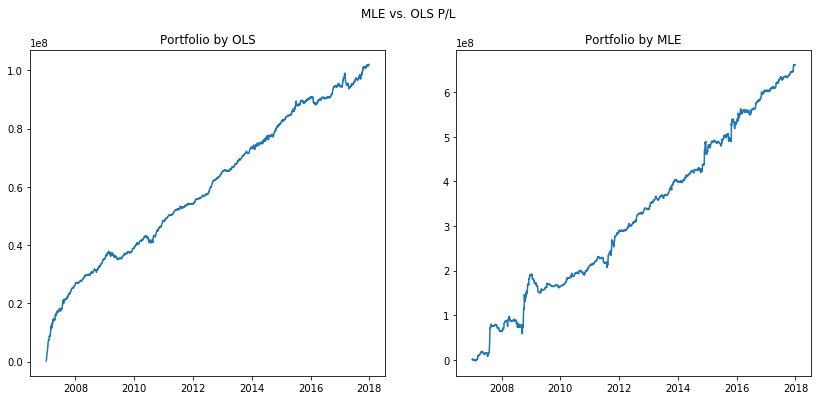

In [192]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plt.suptitle('MLE vs. OLS P/L')
ax[0].plot(cumpnl_res['pnl'])
ax[0].set_title('Portfolio by OLS')
ax[1].plot(mle_pnl.cumsum()['pnl'])
ax[1].set_title('Portfolio by MLE')

## Portfolio optimization with long-only constraint

In [ ]:
holding_long_df = compute_optimal_holding(factor_ret_mle, kappa=1, long_only=True)
# eleminate non-positive holdings
holding_long_df = holding_long_df.loc[holding_long_df.min(1)>=0, :]

In [157]:
holding_long_df = holding_long_df.astype('float64')
holding_long_df.to_csv('holding_long_df.csv')
print('Saved to file ...Done')

Saved to file ...Done


In [100]:
holding_long_df = pd.read_csv('holding_long_df.csv', index_col=0, parse_dates=True)

In [174]:
long_kappa = compute_kappa(holding_long_df)

kappa when average GMV is 500 million USD: 1.5535941493020518e-05


In [206]:
long_pnl = calculate_pnl(holding_long_df, long_kappa)

>>> Running Time :  0:00:09.297196


Text(0.5,1,'Portfolio by MLE long only')

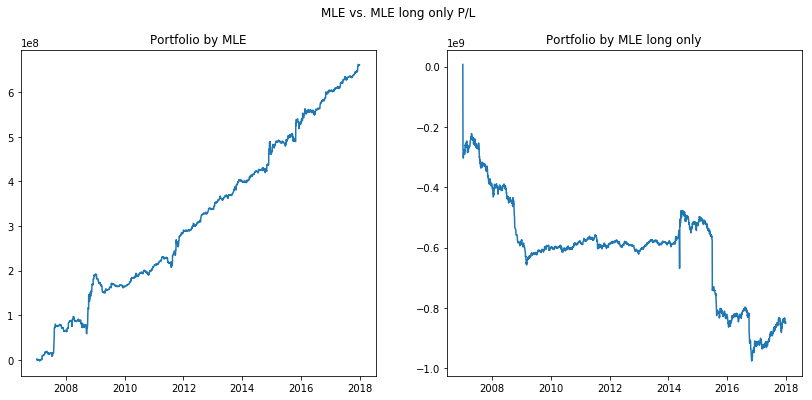

In [207]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
plt.suptitle('MLE vs. MLE long only P/L')
ax[0].plot(mle_pnl.cumsum()['pnl'])
ax[0].set_title('Portfolio by MLE')
ax[1].plot(long_pnl.sort_index().cumsum()['pnl'])
ax[1].set_title('Portfolio by MLE long only')

We can see that long only portfolio using simple Markowitz optimization faces big losses during stock market down time(2008 financial crisis and 2015 stock market sell-off), however, a long-short portfolio tend to profit from the downside during these periods.

# Problem 4: Reinforcement Learning

In [119]:
half_life = 5
lbda = np.log(2)/half_life
sigma = 0.1
eq_price = 50  # mean revert to this price
K = 5  # each maximum trade size in 100 shares
M = 10  # maximum position size in 100 shares
tick_size = 0.1
lot_size = 100.

In [121]:
action_space = np.arange(-K, K+1) * lot_size  # trade_size in action space
holding_space = np.arange(-M, M+1) * lot_size  # in 100 shares
price_space = np.arange(1,1000+1) * tick_size

In [122]:
'simulate price'
def simulate_price(eq_price, lbda, sigma, periods):
    x = 0
    price_list = [eq_price]
    for i in range(periods-1):
        x += - lbda * x + sigma * np.random.normal()
        p = eq_price * np.exp(x)
        p = max(0.1, min(100., p))
        price_list.append(p)
    price_list = np.array(price_list)
    print('Simulate prices of {} days ...Done'.format(periods))
    return price_list

In [123]:
def calculate_cost(trade_size):
    spread_cost = tick_size * abs(trade_size)  # for each trade
    impact_cost = trade_size ** 2 * tick_size / lot_size  # permanent price impact
    total_cost = spread_cost + impact_cost
    return total_cost

In [124]:
learning_rate = 10e-4
gamma = 0.999  # discount rate
alpha = 0.001  # step size
eps = 0.1
periods = 500000
N = 252  # days per year
Q = np.zeros((len(holding_space)*len(price_space), len(action_space)))

In [125]:
price_list = simulate_price(eq_price, lbda, sigma, periods)

Simulate prices of 500000 days ...Done


In [152]:
holding_list = [0]  # initial holding is 0
pnl_list = [0]
ret_list = []
trade_size = 0
start = datetime.now()
print('Q learning ...')

for i in range(1,periods-1):
    last_trade_size = trade_size
    next_price = price_list[i+1]
    curr_price = price_list[i]
    next_price_loc = int(next_price/tick_size-1)  # location of price
    curr_price_loc = int(curr_price/tick_size-1)
    
    'get trade size that gives maximum value in the next state'
    # possible action given latest holding
    last_holding = holding_list[-1]
    poss_action = list(set(action_space).intersection(set(holding_space-last_holding)))
    poss_action.sort()
    poss_action = np.array(poss_action)
    poss_action_loc = (poss_action/lot_size + K).astype(int)  # location of possible actions in Q
    
    # get Q with possible action and holding
    q = Q[next_price_loc*len(holding_space) : next_price_loc*(len(holding_space)+1), poss_action_loc]
    maxq = q.max()  # one number: maximum among all (holding, action)
    # location of every possible (holding, action) that produces max value
    maxq_action_loc = np.where(q == maxq)[1]  # maximum action location for every pair
    random_action_loc = np.random.choice(maxq_action_loc)  # random one pair's action value location
    trade_size = poss_action[random_action_loc]  # corresponding trade size
    
    'eps probability of choosing a random action from possible actions'
    if (np.random.uniform() < eps):
        trade_size = np.random.choice(poss_action)
    
    'current holding'
    holding = last_holding + trade_size
    holding_list.append(holding)
    
    'cost and profit'
    total_cost = calculate_cost(trade_size)
    profit = -(holding * (next_price - curr_price) - total_cost)
    pnl_list.append(profit)
    ret = profit / abs(holding * curr_price)
    ret_list.append(ret)
    reward = profit - 0.5 * learning_rate * profit**2
    
    'update Q'
    target = reward + gamma * maxq
    q = Q[curr_price_loc*len(holding_space) + int(last_holding/lot_size+M), int(last_trade_size/lot_size + K)]
    Q[curr_price_loc*len(holding_space) + int(last_holding/lot_size+M), 
      int(last_trade_size/lot_size + K)] = (1-alpha) * q + alpha * target

print(">>> Running Time : ", datetime.now() - start)

Q learning ...
>>> Running Time :  0:01:45.794302


In [153]:
cumpnl_list = pd.Series(pnl_list).cumsum()
ret_list = np.array(ret_list)
ret_list = ret_list[ret_list != np.inf]
ret_list = ret_list[ret_list != -np.inf]
print('Sharpe ratio is ', np.sqrt(N) * np.nanmean(ret_list)/np.nanstd(ret_list))

Sharpe ratio is  0.1613300722507982


Text(0.5,1,'Q-learning PNL')

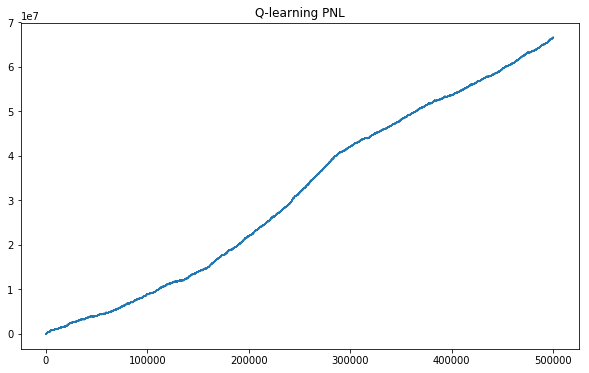

In [1284]:
cumpnl_list.plot(figsize=(10,6))
plt.title('Q-learning PNL')